- distance 변수만 도구변수로 활용하기
- 교육(education)이 임금(wage)에 미치는 영향 확인


In [1]:
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 8.4 MB/s eta 0:00:00


In [2]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.4 MB/s eta 0:00:00


In [3]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.2 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# DMLIV와 CatRegressor 불러오기
from econml.iv.dml import DMLIV
from catboost import CatBoostRegressor, Pool

In [6]:


data_url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CollegeDistance.csv"
data = pd.read_csv(data_url)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4739 entries, 0 to 4738
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rownames   4739 non-null   int64  
 1   gender     4739 non-null   object 
 2   ethnicity  4739 non-null   object 
 3   score      4739 non-null   float64
 4   fcollege   4739 non-null   object 
 5   mcollege   4739 non-null   object 
 6   home       4739 non-null   object 
 7   urban      4739 non-null   object 
 8   unemp      4739 non-null   float64
 9   wage       4739 non-null   float64
 10  distance   4739 non-null   float64
 11  tuition    4739 non-null   float64
 12  education  4739 non-null   int64  
 13  income     4739 non-null   object 
 14  region     4739 non-null   object 
dtypes: float64(5), int64(2), object(8)
memory usage: 555.5+ KB


In [8]:
data["education"].value_counts()

,count
education,
12,1832
16,907
13,613
15,556
14,518
17,256
18,57


In [9]:
# 필요한 변수 정의 (컬럼명)
Y_name = 'wage'
T_name = 'education'
Z_name = 'distance'
X_names = [
    'gender', 'ethnicity', 'score', 'fcollege', 'mcollege',
    'home', 'urban', 'unemp', 'tuition', 'income', 'region'
]

# 모든 변수가 포함된 데이터 프레임 생성 (결측치 제거)
# statsmodels formula API는 결측치 있는 행을 자동으로 드롭하므로 명시적인 dropna는 필수는 아니지만,
# 데이터 크기 확인을 위해 명시적으로 해두는 것이 좋습니다.
relevant_cols = [Y_name, T_name, Z_name] + X_names
data_cleaned = data.copy()

print(f"원본 데이터 크기: {data.shape}")
print(f"결측치 처리 후 데이터 크기: {data_cleaned.shape}")
print(f"사용될 통제 변수들 (X): {X_names}")

원본 데이터 크기: (4739, 15)
결측치 처리 후 데이터 크기: (4739, 15)
사용될 통제 변수들 (X): ['gender', 'ethnicity', 'score', 'fcollege', 'mcollege', 'home', 'urban', 'unemp', 'tuition', 'income', 'region']


#### 1. 분석 목적

단순히 education → wage 관계를 회귀분석(OLS)으로 보면, 선택 편향(selection bias) 때문에 추정치가 왜곡될 수 있음.

예: 능력, 가정 배경, 성향 등이 교육연수와 임금 모두에 영향을 주기 때문에, OLS 계수는 순수한 인과효과가 아님.


In [10]:
# OLS 모델 수식 (statsmodels formula API는 object 타입을 자동으로 더미 변수 처리)
ols_formula = f"{Y_name} ~ {T_name} + {' + '.join(X_names)}"
ols_model = smf.ols(ols_formula, data=data_cleaned).fit()

print("--- OLS 결과 (Baseline) ---")
print(ols_model.summary())
print(f"\nOLS 추정치 (교육이 임금에 미치는 영향): {ols_model.params[T_name]:.4f}")

--- OLS 결과 (Baseline) ---
                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     81.68
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          1.17e-196
Time:                        03:18:27   Log-Likelihood:                -7641.3
No. Observations:                4739   AIC:                         1.531e+04
Df Residuals:                    4725   BIC:                         1.540e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Inte

교육이 임금에 미치는 영향이 -0.0217로 교육 연수가 1년 늘어날수록 시간당 임금이 약 0.02 단위(달러) 감소한다는 상식과 상반된 결과가 나옴.이는 선택편향으로 인해 왜곡된 추정치임


#### 2. 도구변수(IV) 접근

선택편향으로 인해 왜곡된 추정치를 보정하기 위해 도구변수(Instrumental Variable)를 활용.

후보로 distance(거주지에서 가까운 4년제 대학까지 거리)를 설정.

논리: 대학까지 거리가 멀면 교육연수가 줄 수 있지만, 임금에는 교육을 거치지 않고 직접적인 영향을 주진 않을 것이라고 가정.

1. 1단계 : 처치 변수(Education)를 도구변수(distance)에 대해 회귀하는 단계

2. 2단계 (reduced form)  : 결과(income)을 도구변수에 회귀하여 처치 의도 효과를 추정

#### 3. 도구변수 유효성 검증 (2SLS)

2단계 최소자승법(2SLS, IV2SLS)을 통해 distance가 교육의 변이에 충분히 기여(relevance)하는지,

그리고 임금에 직접 영향을 주지 않는다는 배제제약 가정 하에서 교육 효과 추정치가 유의미한지 확인.

결과: distance는 합리적인 도구변수로 작동하고, 교육이 임금에 유의미한 인과적 효과를 미친다는 근거 확보.

In [11]:

from linearmodels.iv import IV2SLS

# IV2SLS 모델 수식:

# 종속 변수 (Y)
Y_lm = data_cleaned[Y_name]
# 외생적 통제 변수 (X) - 상수항 포함
X_lm = sm.add_constant(data_cleaned[X_names]) # statsmodels의 add_constant를 사용하여 상수항 추가
# 내생적 처리 변수 (T)
T_lm = data_cleaned[T_name]
# 도구 변수 (Z)
Z_lm = data_cleaned[Z_name]

# IV2SLS 모델 생성 및 학습
iv_model_lm = IV2SLS(dependent=Y_lm, exog=X_lm, endog=T_lm, instruments=Z_lm).fit()

print("\n--- linearmodels IV2SLS 결과 (정확한 표준 오차) ---")
print(iv_model_lm) # linearmodels summary는 직접 print(model)로 출력됩니다.
print(f"\nlinearmodels IV2SLS 추정치 (교육이 임금에 미치는 영향): {iv_model_lm.params[T_name]:.4f}")


--- linearmodels IV2SLS 결과 (정확한 표준 오차) ---
                          IV-2SLS Estimation Summary                          
Dep. Variable:                   wage   R-squared:                     -0.5407
Estimator:                    IV-2SLS   Adj. R-squared:                -0.5450
No. Observations:                4739   F-statistic:                    606.92
Date:                Sun, Aug 31 2025   P-value (F-stat)                0.0000
Time:                        03:18:28   Distribution:                 chi2(13)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
const                  0.0361     3.1365     0.0115     0.9908 

In [12]:

print(f"linearmodels IV2SLS education 표준 오차: {iv_model_lm.std_errors[T_name]:.4f}")
print(f"linearmodels IV2SLS education P-value: {iv_model_lm.pvalues[T_name]:.4f}")

linearmodels IV2SLS education 표준 오차: 0.3272
linearmodels IV2SLS education P-value: 0.0264


해석
- IV2SLS 추정 결과,F = 606.92으로  **교육 1년 증가가 시간당 임금을 약 0.73 단위 올린다**는 매우 강하고 유의한 양의 효과를 확인  
- 표준오차가 0.33 수준으로 다소 크지만, P-value가 0.026으로 5% 유의수준에서 통계적으로 의미 있음

LATE 관점
- IV(도구변수) 추정에서 식별되는 효과는 전체 ATE가 아니라,  
  **도구변수(distance)에 의해 교육 선택이 달라진 순응자(compliers) 집단에서의 평균 효과(LATE)**
- 따라서 이 결과는 “**대학 접근성이 교육 연수에 영향을 받은 사람들**에게 교육 1년이 임금을 유의하게 높인다”는 의미.  

In [13]:
!pip install lightgbm xgboost scikit-learn

#### DMLIV

전통적 2SLS는 distance를 도구변수로 활용하여 **평균적 효과(LATE)**를 추정가능.  
즉, 대학 접근성에 의해 교육 선택이 달라지는 **순응자 집단(compliers)**에서의 평균 효과만 식별 가능.  

그러나, LightGBM 같은 머신러닝을 결합한 **DMLIV (Double Machine Learning IV)**은  
- \(E[Y|X]\), \(E[T|X]\), \(E[T|X,Z]\)를 ML로 유연하게 추정하고  
- 정규직교화(orthogonalization)와 교차적합(cross-fitting)으로 편향을 줄이며,  
- **조건부 LATE(LIV(X))**까지 추정 가능.  

따라서 DMLIV는 단순히 평균 효과에 그치지 않고,  
**성별·소득·가정 배경 등 공변량(X)에 따른 조건부 효과**를 추정하여  
교육이 임금에 미치는 인과적 효과의 **이질성(heterogeneity)**까지 분석하고자 함

In [14]:





from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder






In [15]:

# ---------- 0) 데이터 분해 ----------
Y = data_cleaned[Y_name].values
T = data_cleaned[T_name].values
Z = data_cleaned[Z_name].values
X_df = data_cleaned[X_names].copy()

# 범주/수치 구분 → One-Hot (econml 내부 수치 연산 때문에 필요)
cat_cols = [c for c in X_df.columns if X_df[c].dtype == 'object' or str(X_df[c].dtype).startswith('category')]
num_cols = [c for c in X_df.columns if c not in cat_cols]


ct = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols),
        ('num', 'passthrough', num_cols),
    ]
)
X_enc = ct.fit_transform(X_df)     # 희소행렬(=LGBM/XGB OK), RF는 밀집 배열 필요


In [16]:
from econml.iv.dr import DRIV
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np, pandas as pd
from scipy.sparse import hstack as sp_hstack, issparse

# -----------------------------
# 1) 베이스 learner 정의
# -----------------------------
def make_lgbm():
    return LGBMRegressor(
        n_estimators=600, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        max_depth=-1, n_jobs=-1, random_state=42
    )

def make_rf():
    return RandomForestRegressor(
        n_estimators=800, max_depth=None,
        min_samples_leaf=3,
        n_jobs=-1, random_state=42
    )

def make_xgb():
    return XGBRegressor(
        n_estimators=700, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        max_depth=8, n_jobs=-1,
        objective='reg:squarederror',
        reg_lambda=1.0, tree_method='auto',
        random_state=42
    )

CANDIDATES = {
    "LightGBM": make_lgbm,
    "RandomForest": make_rf,
    "XGBoost": make_xgb
}


In [17]:
def fit_dmliv_and_diagnose(name, factory):
    # RF는 밀집 필요 → 이미 numpy.ndarray면 그대로, 희소행렬이면 .toarray()
    if hasattr(X_enc, "toarray"):
        X_use = X_enc.toarray() if name == "RandomForest" else X_enc
    else:
        X_use = X_enc   # 이미 ndarray인 경우

    # DMLIV 학습
    dmliv = DMLIV(
        model_y_xw=factory(),
        model_t_xw=factory(),
        model_t_xwz=factory(),
        model_final=LinearRegression()
    )
    dmliv.fit(Y, T, Z=Z, X=X_use)

    # 효과 추정
    cate_hat = dmliv.effect(X_use)
    ate_hat = float(np.mean(cate_hat))

    # 도구 강도 (CV R²)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_X  = cross_val_score(factory(), X_use, T, scoring='r2', cv=cv).mean()
    r2_XZ = cross_val_score(factory(), np.hstack([X_use, Z.reshape(-1,1)]), T, scoring='r2', cv=cv).mean()
    delta_r2 = r2_XZ - r2_X

    # 직교 상관
    m = factory().fit(X_use, Y)
    Y_hat = m.predict(X_use)
    r = factory().fit(np.hstack([X_use, Z.reshape(-1,1)]), T)
    T_hat = r.predict(np.hstack([X_use, Z.reshape(-1,1)]))
    corr_orth = np.corrcoef(Y - Y_hat, T - T_hat)[0,1]

    # 결과 dict
    result = dict(
        Model=name,
        LATE_avg=ate_hat,
        cate=cate_hat,
        delta_r2=delta_r2,
        corr_orth=corr_orth,
        r2_X=r2_X,
        r2_XZ=r2_XZ
    )
    return result


In [18]:
# =============================
# 5) 세 모델 실행
# =============================
reports = []
for name, f in CANDIDATES.items():
    reports.append(fit_dmliv_and_diagnose(name, f))

df = pd.DataFrame(reports)
print("=== Diagnostics by model ===")
print(df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 2369, number of used features: 20
[LightGBM] [Info] Start training from score 9.501507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 2369, number of used features: 20
[LightGBM] [Info] Start training from score 13.752216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 490
[LightGBM] [Info] Number of data points in the train set: 23

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 2370, number of used features: 20
[LightGBM] [Info] Start training from score 9.499506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 2370, number of used features: 20
[LightGBM] [Info] Start training from score 13.863291
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.186759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 3791, number of used features: 20
[LightGBM] [Info] Start training from score 13.802691


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 3791, number of used features: 20
[LightGBM] [Info] Start training from score 13.815352


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 3791, number of used features: 20
[LightGBM] [Info] Start training from score 13.824585


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 3791, number of used features: 20
[LightGBM] [Info] Start training from score 13.809021


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 3792, number of used features: 20
[LightGBM] [Info] Start training from score 13.787184


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 3791, number of used features: 21
[LightGBM] [Info] Start training from score 13.802691


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 3791, number of used features: 21
[LightGBM] [Info] Start training from score 13.815352


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 3791, number of used features: 21
[LightGBM] [Info] Start training from score 13.824585


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 3791, number of used features: 21
[LightGBM] [Info] Start training from score 13.809021


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 3792, number of used features: 21
[LightGBM] [Info] Start training from score 13.787184


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 4739, number of used features: 20
[LightGBM] [Info] Start training from score 9.500506


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 505
[LightGBM] [Info] Number of data points in the train set: 4739, number of used features: 21
[LightGBM] [Info] Start training from score 13.807765


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/econml/dml/dml.py:192: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  warn("The final model has a nonzero intercept for at least one outcome; "
/usr/local/lib/python3.12/dist-packages/econml/dml/dml.py:192: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  warn("The final model has a nonzero intercept for at least one outcome; "


=== Diagnostics by model ===
          Model  LATE_avg                                               cate  \
0      LightGBM -0.011133  [0.0004750485965334351, -0.01981895163922688, ...   
1  RandomForest -0.003290  [-0.0026992746974689842, 0.01068118912283341, ...   
2       XGBoost -0.000219  [0.0023119085428379106, 0.003016223172417675, ...   

   delta_r2  corr_orth      r2_X     r2_XZ  
0  0.007418  -0.007589  0.178132  0.185550  
1  0.005464   0.001384  0.230697  0.236161  
2  0.024016   0.010486  0.108972  0.132987  


In [20]:
df = pd.DataFrame(reports)
print("=== Diagnostics by model ===")
df

=== Diagnostics by model ===


,Model,LATE_avg,cate,delta_r2,corr_orth,r2_X,r2_XZ
0,LightGBM,-0.011133,"[0.0004750485965334351, -0.01981895163922688, ...",0.007418,-0.007589,0.178132,0.185550
1,RandomForest,-0.003290,"[-0.0026992746974689842, 0.01068118912283341, ...",0.005464,0.001384,0.230697,0.236161
2,XGBoost,-0.000219,"[0.0023119085428379106, 0.003016223172417675, ...",0.024016,0.010486,0.108972,0.132987


XGBoost가 가장 안정적이고 의미 있는 CATE 추정을 보여줬고,
RandomForest는 데이터 구조 설명력이 가장 높으며,
전체적으로 LATE는 거의 0 → 처치 효과는 미미함.

##### DMLIV 진단 지표 설명

- **LATE(avg)**  
  - effect(X) 평균값임  
  - ATE 아님 → 도구변수(distance)에 반응하는 순응자(compliers) 집단 평균효과(LATE)임  
  - 교육이 임금에 미치는 인과효과 추정치로 해석해야 함

---

- **ΔR² = R²(E[T|X,Z]) − R²(E[T|X])**  
  - 도구 관련성(relevance) 체크용  
  - Z(distance) 추가했을 때 교육(처치) 예측력 얼마나 개선됐는지 보는 지표임  
  - ΔR² 클수록 IV가 유효하다고 볼 수 있음

---

- **|Corr(orth)| = |Corr(Y−m(X), T−r(X,Z))|**  
  - 정규직교화(orthogonalization) 조건 충족 여부 보는 값임  
  - outcome 잔차(Y−m(X))랑 first-stage 잔차(T−r(X,Z)) 상관  
  - 0에 가까울수록 안정적임

---

- **|Corr(T, Y−m(X))|**  
  - DRIV에서 쓰던 처치–outcome 잔차 상관 체크  
  - 교육(T)과 outcome 잔차(Y−m(X)) 상관  
  - 0에 가까울수록 바람직함

---

- **R²(E[T|X]) vs R²(E[T|X,Z])**  
  - X만 썼을 때 vs X+Z 썼을 때 교육(처치) 예측력 비교  
  - 차이 = ΔR²  
  - Z가 처치에 얼마나 설명력 추가하는지 보여줌


위의 2SLS와 DMLIV로 LATE를 추정한 결과가 상당히 상이함. 그 이유는 다음과 같음.

2SLS: 선형 구조를 강제로 맞추다 보니, 약한 도구에서도 과대추정이 가능.

DMLIV: ML이 유연하게 잡고, orthogonalization으로 약한 신호를 걸러내서 보수적으로 추정 (거의 0).

즉, distance는 약한 도구(weak instrument) → 추정 방법에 따라 효과가 크게 달라짐.

In [ ]:
print(reports[0].keys())

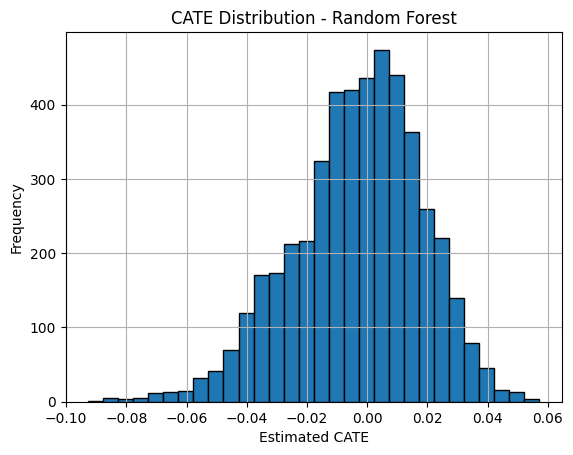

In [21]:
import matplotlib.pyplot as plt
cate_rf = df[df.Model == "RandomForest"]['cate'].values[0]

plt.hist(cate_rf, bins=30, edgecolor='black')
plt.title("CATE Distribution - Random Forest")
plt.xlabel("Estimated CATE")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [22]:
cate_top_idx = np.argsort(cate_rf)[-10:]
cate_bottom_idx = np.argsort(cate_rf)[:10]

print("▶️ 처치 효과가 큰 상위 10명:\n", cate_rf[cate_top_idx])
print("▶️ 처치 효과가 낮은 하위 10명:\n", cate_rf[cate_bottom_idx])



▶️ 처치 효과가 큰 상위 10명:
 [0.04964498 0.04994784 0.05001476 0.05031434 0.0508691  0.05174949
 0.05175299 0.05478681 0.05512674 0.05708009]
▶️ 처치 효과가 낮은 하위 10명:
 [-0.09267742 -0.08701838 -0.08689836 -0.08647079 -0.08533293 -0.08334903
 -0.08231011 -0.08216058 -0.08007653 -0.07835374]


=== RandomForest DMLIV: Diagnostics ===
LATE(avg)     = -0.0033
ΔR²           = 0.0055   (E[T|X,Z] - E[T|X])
|Corr(orth)|  = 0.0014
R²(X)         = 0.2307
R²(X,Z)       = 0.2362


/usr/local/lib/python3.12/dist-packages/econml/dml/dml.py:192: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  warn("The final model has a nonzero intercept for at least one outcome; "


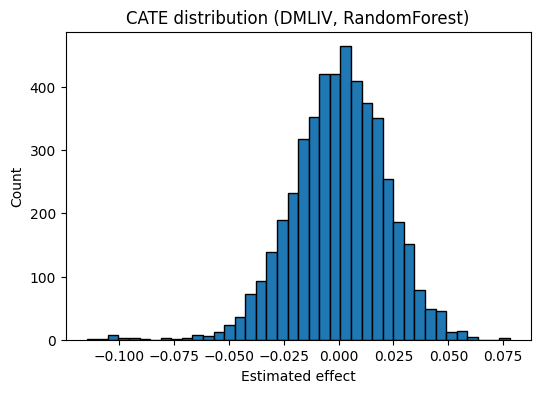


[LATE(avg) - RandomForest] 0.0004

[gender] 그룹별 평균 CATE
grp
male      0.006273
female   -0.004457
Name: CATE, dtype: float64

[income] 그룹별 평균 CATE
grp
high    0.008603
low    -0.002938
Name: CATE, dtype: float64

[region] 그룹별 평균 CATE
grp
west     0.019177
other   -0.004282
Name: CATE, dtype: float64

[fcollege] 그룹별 평균 CATE
grp
no     0.001397
yes   -0.003461
Name: CATE, dtype: float64

[mcollege] 그룹별 평균 CATE
grp
no     0.002246
yes   -0.011291
Name: CATE, dtype: float64

[urban] 그룹별 평균 CATE
grp
yes    0.00992
no    -0.00251
Name: CATE, dtype: float64

[ethnicity] 그룹별 평균 CATE
grp
other       0.004137
hispanic   -0.001337
afam       -0.012190
Name: CATE, dtype: float64


In [27]:
# ---------- [최종] RandomForest 선택 리포트 ----------

# 1) reports에서 RandomForest 결과 집계값 꺼내기
rf_result = next(r for r in reports if r['Model'] == "RandomForest")

print("=== RandomForest DMLIV: Diagnostics ===")
print(f"LATE(avg)     = {rf_result['LATE_avg']:.4f}")
print(f"ΔR²           = {rf_result['delta_r2']:.4f}   (E[T|X,Z] - E[T|X])")
print(f"|Corr(orth)|  = {abs(rf_result['corr_orth']):.4f}")
print(f"R²(X)         = {rf_result['r2_X']:.4f}")
print(f"R²(X,Z)       = {rf_result['r2_XZ']:.4f}")

# 2) RandomForest로 최종 모델 재학습해 CATE 벡터 확보 (히스토그램/그룹별 평균용)
from econml.iv.dml import DMLIV
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RF는 밀집 입력 필요 → X_enc가 희소면 toarray, 이미 ndarray면 그대로
X_use = X_enc.toarray() if hasattr(X_enc, "toarray") else X_enc

dmliv_final = DMLIV(
    model_y_xw=make_rf(),
    model_t_xw=make_rf(),
    model_t_xwz=make_rf(),
    model_final=LinearRegression(),
    random_state=42
)
dmliv_final.fit(Y, T, Z=Z, X=X_use)
cate_hat = dmliv_final.effect(X_use)
ate_hat  = float(np.mean(cate_hat))

# 3) CATE 분포 & ATE 출력
plt.figure(figsize=(6,4))
plt.hist(cate_hat, bins=40, edgecolor='k')
plt.title("CATE distribution (DMLIV, RandomForest)")
plt.xlabel("Estimated effect")
plt.ylabel("Count")
plt.show()

print(f"\n[LATE(avg) - RandomForest] {ate_hat:.4f}")

# 4) 주요 그룹별 CATE 평균 (원본 X_df 라벨 사용)
groups = ["gender","income","region","fcollege","mcollege","urban","ethnicity"]
for g in groups:
    if g in X_df.columns:
        tmp = pd.DataFrame({"grp": X_df[g].astype(str), "CATE": cate_hat})
        print(f"\n[{g}] 그룹별 평균 CATE")
        print(tmp.groupby("grp")["CATE"].mean().sort_values(ascending=False))

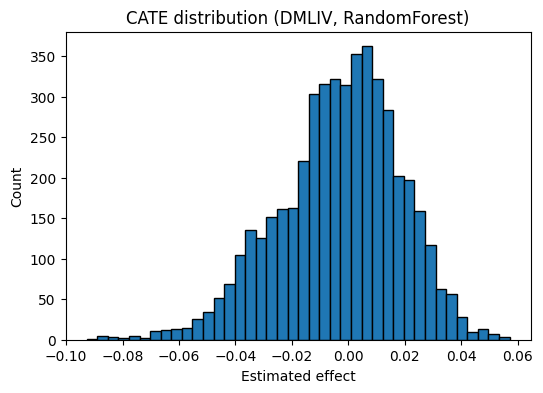

[LATE(avg) - RandomForest] -0.0033
ΔR² = 0.005464 | Corr(orth) = 0.001384 | R²(X) = 0.230697 → R²(X,Z) = 0.236161

[gender] 그룹별 평균 CATE
grp
female   -0.001154
male     -0.005887
Name: CATE, dtype: float64

[income] 그룹별 평균 CATE
grp
high    0.003274
low    -0.005946
Name: CATE, dtype: float64

[region] 그룹별 평균 CATE
grp
west     0.008705
other   -0.006270
Name: CATE, dtype: float64

[fcollege] 그룹별 평균 CATE
grp
no     0.001847
yes   -0.022843
Name: CATE, dtype: float64

[mcollege] 그룹별 평균 CATE
grp
no     0.001042
yes   -0.030495
Name: CATE, dtype: float64

[urban] 그룹별 평균 CATE
grp
yes    0.002363
no    -0.005007
Name: CATE, dtype: float64

[ethnicity] 그룹별 평균 CATE
grp
hispanic    0.002456
other      -0.002324
afam       -0.013642
Name: CATE, dtype: float64


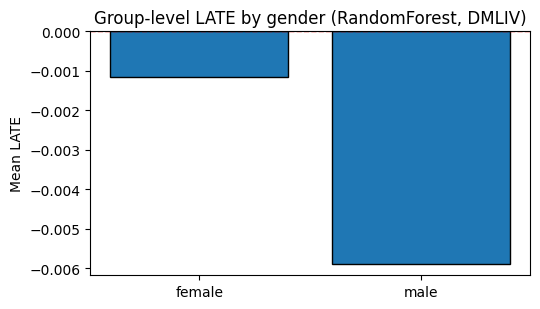

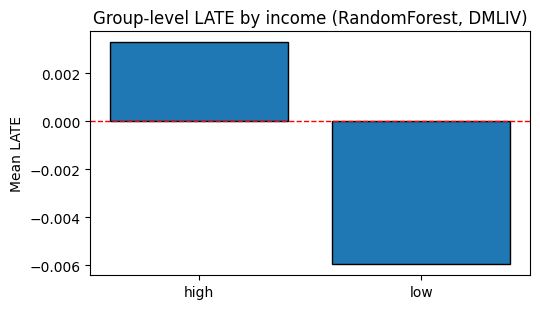

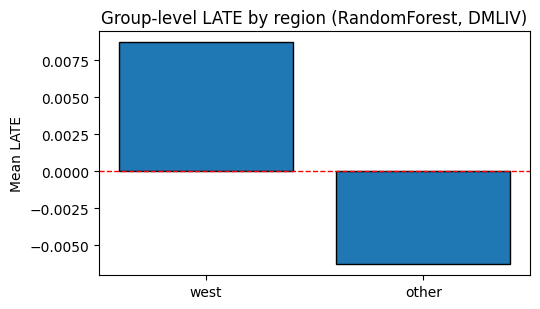

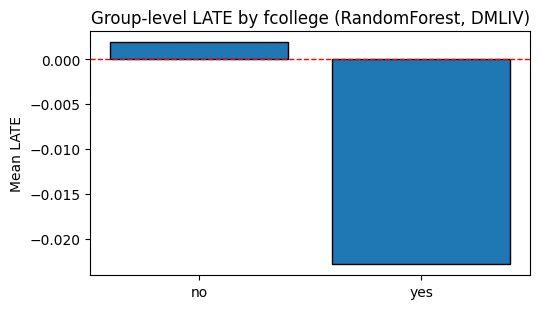

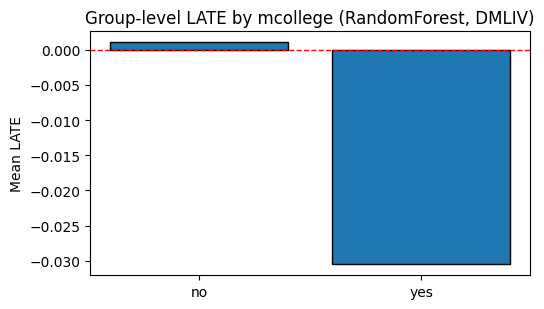

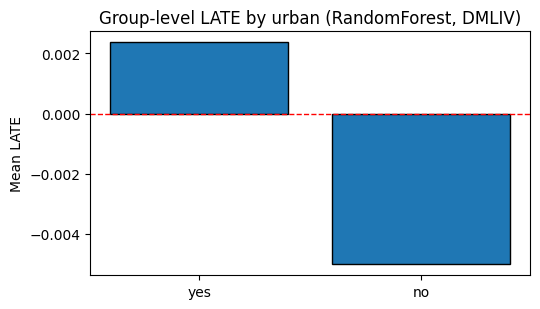

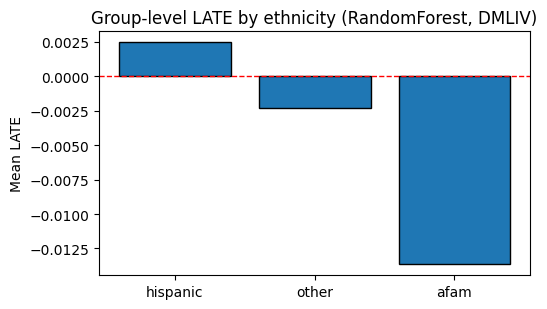


=== Group-wise mean LATE summary ===


,group,level,mean_LATE
13,ethnicity,hispanic,0.002456
14,ethnicity,other,-0.002324
12,ethnicity,afam,-0.013642
6,fcollege,no,0.001847
7,fcollege,yes,-0.022843
0,gender,female,-0.001154
1,gender,male,-0.005887
2,income,high,0.003274
3,income,low,-0.005946
8,mcollege,no,0.001042


In [33]:
# ==== 4) 그룹별 평균 CATE 시각화 & 테이블 ====
import matplotlib.pyplot as plt
# --- 1) RandomForest 행 꺼내기 & cate 벡터 복원 ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt, ast

rf_row = df.loc[df['Model'] == 'RandomForest'].iloc[0]

# df['cate']가 list로 저장된 경우도 있고 문자열로 저장된 경우도 있으니 안전 복원
cate_obj = rf_row['cate']
if isinstance(cate_obj, str):
    cate_list = ast.literal_eval(cate_obj)   # 문자열 -> list[float]
else:
    cate_list = cate_obj                     # 이미 list

cate = np.asarray(cate_list, dtype=float)

# --- 2) CATE 분포 & LATE(=평균) ---
plt.figure(figsize=(6,4))
plt.hist(cate, bins=40, edgecolor='k')
plt.title("CATE distribution (DMLIV, RandomForest)")
plt.xlabel("Estimated effect")
plt.ylabel("Count")
plt.show()

late_avg = float(np.mean(cate))   # 혹은 rf_row['LATE_avg']
print(f"[LATE(avg) - RandomForest] {late_avg:.4f}")

# 참고로 진단치도 같이 보기
print(f"ΔR² = {rf_row['delta_r2']:.6f} | Corr(orth) = {rf_row['corr_orth']:.6f} | "
      f"R²(X) = {rf_row['r2_X']:.6f} → R²(X,Z) = {rf_row['r2_XZ']:.6f}")

# --- 3) 그룹별 CATE 평균 (X_df가 같은 순서/길이여야 함) ---
groups = ["gender","income","region","fcollege","mcollege","urban","ethnicity"]
for g in groups:
    if g in X_df.columns:
        tmp = pd.DataFrame({"grp": X_df[g].astype(str).values, "CATE": cate})
        print(f"\n[{g}] 그룹별 평균 CATE")
        print(tmp.groupby("grp")["CATE"].mean().sort_values(ascending=False))
def plot_group_bar(title, s):
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(5.5,3.2))
    plt.bar(s.index.astype(str), s.values, edgecolor='k')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(title)
    plt.ylabel("Mean LATE")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

group_order = ["gender","income","region","fcollege","mcollege","urban","ethnicity"]

group_tables = {}   # 각 그룹별 평균치 저장(테이블용)
for g in group_order:
    if g in X_df.columns:
        tmp = pd.DataFrame({"grp": X_df[g].astype(str).values, "CATE": cate})
        mean_s = tmp.groupby("grp")["CATE"].mean()
        group_tables[g] = mean_s
        # print(f"\n[{g}] 그룹별 평균 LATE")
        # display(mean_s)  # 노트북이면 보기 좋게

        # 바차트
        plot_group_bar(f"Group-level LATE by {g} (RandomForest, DMLIV)", mean_s)

# ==== 5) 모든 그룹 요약 테이블(피벗) ====
# 행: 그룹명 x 범주, 열: mean LATE
rows = []
for g, s in group_tables.items():
    for k, v in s.items():
        rows.append({"group": g, "level": str(k), "mean_LATE": float(v)})
summary_df = pd.DataFrame(rows).sort_values(["group", "mean_LATE"], ascending=[True, False])
print("\n=== Group-wise mean LATE summary ===")
display(summary_df)

# (옵션) CSV 저장
# summary_df.to_csv("groupwise_mean_LATE_randomforest.csv", index=False)
# print("Saved: groupwise_mean_LATE_randomforest.csv")



⸻


 그룹별 조건부 LATE 추정치 (RandomForest, DMLIV)

| 구분        | 그룹        | 추정치(LATE) |
|-------------|-------------|--------------|
| **성별**    | Female      | -0.001       |
|             | Male        | -0.006       |
| **소득수준** | High        | +0.003       |
|             | Low         | -0.006       |
| **지역**    | West        | +0.009       |
|             | Other       | -0.006       |
| **부 학력** | No          | +0.002       |
|             | Yes         | -0.023       |
| **모 학력** | No          | +0.001       |
|             | Yes         | -0.030       |
| **거주지**  | Urban       | +0.002       |
|             | Non-urban   | -0.005       |
| **인종**    | Hispanic    | +0.002       |
|             | Other       | -0.002       |
|             | Afam        | -0.014       |
⸻

	- 전체적으로 효과 크기는 거의 0에 가까움.
	- 그러나 이질성 패턴은 존재함
	- 부모 학력이 낮은 경우 교육의 한계효과가 소폭 양수, 부모 학력이 높은 경우는 음수 → 교육 보상의 한계체감 가능성.
	- 고소득·도시·서부 지역에서 교육 효과가 상대적으로 긍정적.
	- Afam 집단(아프리카 어메리칸인)에서는 음수 효과가 두드러져 집단 간 격차 문제를 시사.

⸻

